# Getting reasonable learners running

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

from ipywidgets import widgets
from IPython.display import display

import numpy as np
import torch
import pytorch_lightning as pl

from torch import nn

## First, developing the function learner outside the RL context

This is a key step for me

In [14]:
%run simpleModels.py
import pytorch_lightning as pl

In [15]:
oscillator = lambda x: torch.cos(10*x) +1
square = lambda x: x**2

model = functionLearner(target=oscillator)
trainer = pl.Trainer(max_epochs=300)
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 67.6 K
1 | loss    | MSELoss    | 0     
---------------------------------------
67.6 K    Trainable params
0         Non-trainable params
67.6 K    Total params
0.270     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


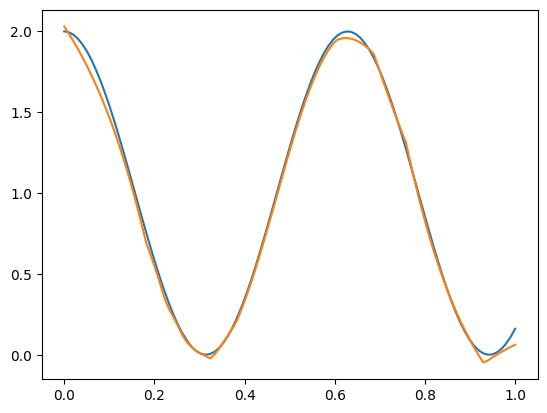

In [16]:
xs = torch.linspace(0,1, 100)[:,None]
ytrue = model.target(xs).detach()
yfit = model.eval().forward(xs).detach()

xtrain, ytrain = model.data[:]

plt.plot(xs, ytrue)
plt.plot(xs, yfit)
#plt.plot(xtrain, ytrain, '.')

### Thoughts while implementing FFNNs

1. Shallow architectures with wide middle layers seem to be the way to go.
2. ReLUs over Sigmoids or Tanhs: the trouble with these non-linearities seems to be their limited dynamic range, which makes them mostly effective for zero mean, unit variance activity, in any layer they work on. However, this is also an issue with ReLUs, which are only non-linear around 0.
3. Along these lines, centering and unitizing variance for the input data is, of course, very important.
4. I bumped up the learning rate in Adam, seems to have been effective.
5. SoftPlus and other output non-linearities seem to make the learning task much harder, due to having to learn this warping of outputs. However, absolute values also seem to add 'kinks' to small values, near zero.
6. We don't actually need that many epochs of training with this set-up. For a simple quadratic, double digits does just fine
7. Smaller batch sizes are better. 32 as a default. I also like to shuffle batches.

#### One persistant issue seems to be with the endpoints, which tend to look linear.
More generally, we often seem to get linear segments of the fit curves. This might reflect the fact that many of the neurons are set to zero (sequentially so, in fact), so the representation becomes much sparser than the dimensions might lead you to believe. A few ways to address this are
- dropout
- layer normalization
- batch normalization
- resampling the training data to emphasize the endpoints

I tried layer normalization and dropout. (I don't like the sensitivity of batch normalization to batch size, although this can of course be compensated by adjusting the momentum of the batch normalizer). Both seem to show improvements, although dropout unsurprisingly requires much greater training times. There are also some intersting studies of the interactions between these (https://arxiv.org/pdf/1801.05134.pdf).

#### Conclusions:
After fiddling around with architectures, training parameters, and targets, trying to produce a neural network architecture that is good at fitting a general one-dimensional function, I have come to some conclusions. Generally, this seems somewhat feasible with reasonable performance, but costly in terms of train time, as well as hyperparameter optimization, which could well be sensitive to the class of functions that it is performed over. I think that this is not a task that neural networks are very well fit to, and they are certainly not the go-to technique. Instead, for an out-of-the-box approach, gaussian processes would be much better. Also, this isn't the right approach for my problem: we have discrete times, so one-hot encoding of time vectors seems to be the way to go.



### Quick test of embedding models

Using a embedding as an implicit one-hot encoding of time, we want to be able to fit a variety of parameter values at different times.

In [1]:
%run simpleModels.py

In [4]:
pureEmbedding = discreteLearner(middleDimension=0)
linearEmbedding = discreteLearner()

trainer1 = pl.Trainer(max_epochs=2000)
trainer2 = pl.Trainer(max_epochs=2000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer1.fit(pureEmbedding)


  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 20    
1 | loss    | MSELoss    | 0     
---------------------------------------
20        Trainable params
0         Non-trainable params
20        Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [6]:
trainer2.fit(linearEmbedding)


  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 74    
1 | loss    | MSELoss    | 0     
---------------------------------------
74        Trainable params
0         Non-trainable params
74        Total params
0.000     Total estimated model params size (MB)
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [7]:
pureEmbedding.targets

tensor([[196.8358,   5.7920],
        [ 45.2559, 105.6455],
        [239.5801,  80.8389],
        [ 86.7418,  13.5262],
        [ 93.2765, 179.4289],
        [221.8630,  38.3120],
        [ 11.2010,  67.7073],
        [ 29.5859, 113.6475],
        [ 23.3395,   2.4194],
        [ 91.5970, 211.9329]])

In [8]:
linearEmbedding.targets

tensor([[ 65.3575, 103.0626],
        [  8.0413,   7.0608],
        [185.2644, 372.3418],
        [ 44.4116, 276.0028],
        [ 77.0311, 265.3201],
        [ 67.1682, 229.9326],
        [ 55.3957,  22.7674],
        [ 57.1928,  59.4016],
        [ 48.1020,  83.9647],
        [317.1703, 717.4990]])

In [10]:
print('Embedding error:', (pureEmbedding.forward(torch.arange(0,10)) - pureEmbedding.targets).norm() )
print('With linear error:', (linearEmbedding.forward(torch.arange(0,10)) - linearEmbedding.targets).norm() )

Embedding error: tensor(337.6561, grad_fn=<LinalgVectorNormBackward0>)
With linear error: tensor(0.6638, grad_fn=<LinalgVectorNormBackward0>)


This doesn't seem to change much across samples: only the embedding is slow to learn, and tends cluster the outputs more. Six dimensional embedding is sufficient to learn variable outputs with small error.

## Even with this architecture, I'm getting very low certainty results

This leads me to two experiments:
1. Use the ground truth value function, to see if actor-critic could be a way out
2. Apply the same learner to a simple environment to see if the reward statistics are hampering convergence



In [4]:
from groundTruth import findBestAction_determ, findBestAction

for i in range(11):
    print(i, findBestAction_determ(0.01*i, 0.25*(i**0.5), 1., np.sqrt).x )

/Users/luke/Documents/researchProjects/portfolioRL/groundTruth.py:37: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -quad(toIntegrate, 0., np.inf)[0]  # negative to minimize
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2411: RuntimeWarning: invalid value encountered in analyticObjective (vectorized)
  outputs = ufunc(*inputs)


0 [0.5]
1 [0.31727411]
2 [0.31495428]
3 [0.31203661]
4 [0.30953226]
5 [0.30712127]
6 [0.30481403]
7 [0.30261264]
8 [0.30051825]
9 [0.29853172]
10 [0.29665147]


### Simple environment

Here, I'm applying the same learner to a continuous bandit problem: reward $-(x - 0.5)^2 + 0.25$ plus noise

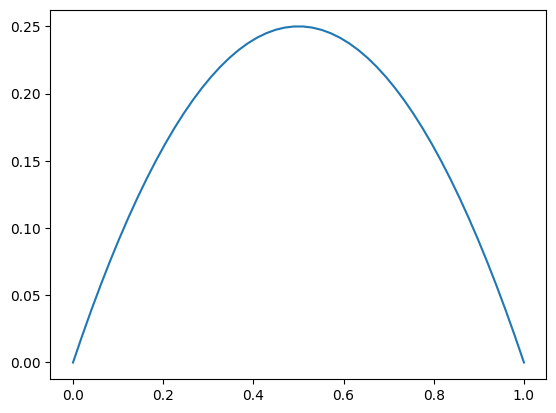

In [19]:
xs = np.linspace(0,1)
plt.plot(xs, -(xs - 0.5)**2 +0.25)

In [56]:
%run environment.py
%run agents.py


In [57]:
TL =  TimeLearner( timehorizon=1, utilityFn=lambda x:x, batch_size=5000, n_experiments=100)
TL.E = AllocationBandit(0,0,0)
trainer = pl.Trainer(max_epochs=1000)

trainer.fit(TL)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params
-----------------------------------------
0 | policyNet | Sequential | 74    
-----------------------------------------
74        Trainable params
0         Non-trainable params
74        Total params
0.000     Total estimated model params size (MB)


"baseline":       cashout
"batch_size":     5000
"lr":             0.001
"mu":             0.1
"n_experiments":  100
"regularization": 0
"sigma":          0.1
"timehorizon":    1
"utilityFn":      None


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


In [63]:
TL.forward(torch.arange(0,10)[:,None].repeat((1, 3)) )

tensor([[3.6745, 0.2012],
        [0.8696, 0.3658],
        [1.3614, 0.2995],
        [2.4175, 0.8286],
        [1.4992, 0.6215],
        [0.5196, 0.3525],
        [0.3837, 0.1172],
        [0.1887, 0.0837],
        [1.1906, 0.0892],
        [0.4689, 0.1301]], grad_fn=<AbsBackward0>)

Ok. This looks like a sign of an underlying issue: even for this easy task, the Beta distribution learner does not appear to learn a deterministic policy that concentrates on one action.

### Examining the Beta distribution in more detail

In [69]:
from torch.distributions import Beta, Normal

Text(0.5, 1.0, 'Confidence gradient at max likelihood input')

<Figure size 1000x300 with 0 Axes>

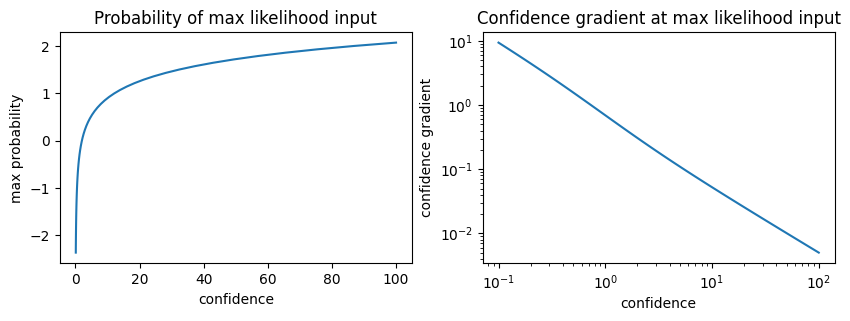

In [43]:
confidences = torch.logspace(-1, 2, 50)

probabilities = []
gradients = []

for confidence in confidences:
    confidence.requires_grad = True
    
    dist = Beta( 0.5*confidence, 0.5*confidence)

    maxProb = dist.log_prob(torch.tensor(0.5))
    probabilities.append(maxProb.item())
    maxProb.backward()
    gradients.append( confidence.grad.item())


figsize(10,3)
plt.tight_layout()
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.plot(confidences.detach(), probabilities)
plt.ylabel('max probability')
plt.xlabel('confidence')
plt.title('Probability of max likelihood input')
plt.subplot(1,2,2)
plt.loglog(confidences.detach(), gradients)
plt.ylabel('confidence gradient')
plt.xlabel('confidence')
plt.title('Confidence gradient at max likelihood input')

Here we see major issues with the Beta distribution. Most importantly, in the right-hand (log-log) plot, the gradient of confidence is _decreasing_ in confidence (by what appears to be a power law). This means that, as the confidence get larger, it becomes more and more difficult to increase confidence, so more and more steps will be required. This explains the failure to converge to high confidence distributions that I've been seeing in my learners.

Similarly, although I think less impactful, is the fact that increases in confidence see diminishing returns in terms of how much they boost the probability of the max-likelihood input. Thus, as confidence gets larger, it needs to change even more to boost the log-probability by the same amount.

For a distribution that will converge to deterministic, we certainly want the confidence gradient not to decrease as confidence increases.

### Normal Distribution

Text(0.5, 1.0, 'Confidence gradient at max likelihood input')

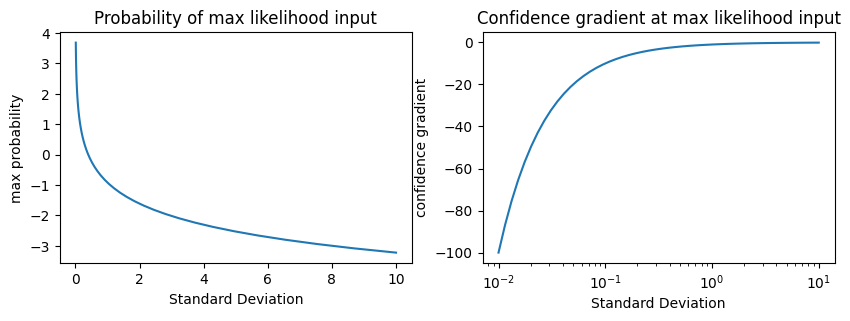

In [49]:
standardDevs = torch.logspace(-2, 1, 50)

probabilities = []
gradients = []

for standardDev in standardDevs:
    standardDev.requires_grad = True
    
    dist = Normal( torch.tensor(0.), standardDev)

    maxProb = dist.log_prob(torch.tensor(0.))
    probabilities.append(maxProb.item())
    maxProb.backward()
    gradients.append( standardDev.grad.item())


figsize(10,3)

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.plot(standardDevs.detach(), probabilities)
plt.ylabel('max probability')
plt.xlabel('Standard Deviation')
plt.title('Probability of max likelihood input')
plt.subplot(1,2,2)
plt.semilogx(standardDevs.detach(), gradients)
plt.ylabel('confidence gradient')
plt.xlabel('Standard Deviation')
plt.title('Confidence gradient at max likelihood input')


This is a feature of the normal distribution: as the distribution becomes more concentrated (decreasing standard deviation), the gradient becomes even more negative, thereby making it _easier_ to learn even smaller standard deviations. Similarly, at small standard deviations, changes become more impactful to the probability at max-likelihood imput. 

Hence, normal is a very good candidate for encoding policy distributions. It does, however, have to be truncated.

### Beta distribution with exponentiated parameters

Text(0.5, 1.0, 'Confidence gradient at max likelihood input')

<Figure size 1300x300 with 0 Axes>

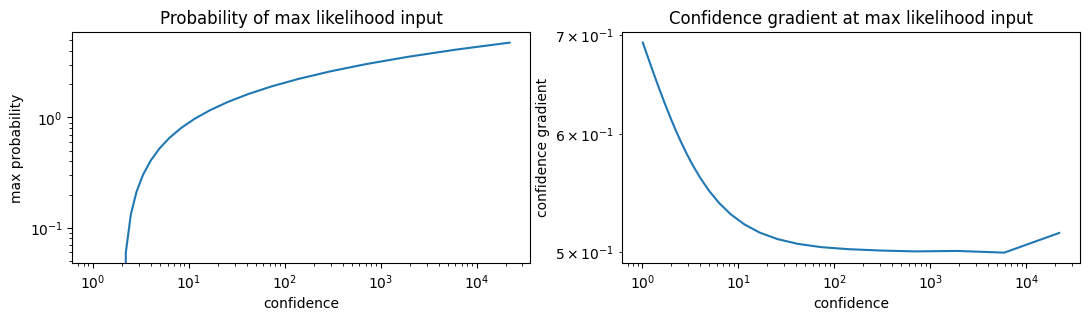

In [62]:
confidences = torch.logspace(-2, 1, 50)

probabilities = []
gradients = []

for confidence in confidences:
    confidence.requires_grad = True
    
    dist = Beta( 0.5*torch.exp(confidence), 0.5*torch.exp(confidence) )

    maxProb = dist.log_prob(torch.tensor(0.5))
    probabilities.append(maxProb.item())
    maxProb.backward()
    gradients.append( confidence.grad.item())


figsize(13,3)
plt.tight_layout()
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.loglog(torch.exp(confidences).detach(), probabilities)
plt.ylabel('max probability')
plt.xlabel('confidence')
plt.title('Probability of max likelihood input')
plt.subplot(1,2,2)
plt.loglog(torch.exp(confidences).detach(), gradients)
plt.ylabel('confidence gradient')
plt.xlabel('confidence')
plt.title('Confidence gradient at max likelihood input')

Adding an exponential non-linearity doesn't turn this around. It does make the gradients flatter, but they are still very small

## Trying gaussian action distributions

Of course, nothing is ever easy, and the Gaussian action distributions suffer from their own issues. 
1. We need more fiddling to get them to converge well
2. There is an issue with action clipping, which is that when the optimal action is 0% or 100%, there are multiple ways to get this result: increasing concentration, or decreasing (increasing) the mean action. So, rather than becoming more concentrated, the distribution can just race away from the interval that we are working with.

This also raises the question of whether we should reinforce the actions that are output (i.e. environment clipping) or the actions that are actually taken (i.e. agent clipping) environment clipping seems to be the norm, but it is sensitive to #2 above

Interestingly, this paper: http://proceedings.mlr.press/v70/chou17a/chou17a.pdf goes in the other direction, promoting the use of beta action distributions over clipped normal distributions by using _natural gradient descent_

This is the direction that I'd like to take.

### Setup for natural gradient descent

In [31]:
data = torch.randn(10,2)

tail = nn.Sequential( nn.Linear(2,20), nn.ReLU())
head = nn.Sequential( nn.Linear(20,20), nn.ReLU(), nn.Linear(20,2))

In [32]:
# full pathway

loss = head( tail( data)).mean()
loss.backward()

headGrads_full = []
tailGrads_full = []
for p in head.parameters():
    headGrads_full.append(p.grad)

for p in tail.parameters():
    tailGrads_full.append(p.grad)

In [63]:
head.zero_grad()
tail.zero_grad()

middle = tail( data)
middle.retain_grad()

loss2 = head( middle ).mean()
loss2.backward(retain_graph=True)


headGrads_partial = []
tailGrads_partial = []
for p in head.parameters():
    headGrads_partial.append(p.grad)


tail.zero_grad()
torch.autograd.backward( middle, grad_tensors=middle.grad)

for p in tail.parameters():
    tailGrads_partial.append(p.grad)


In [66]:
for i in range(len(headGrads_full)):
    print( (headGrads_full[i] - headGrads_partial[i]).norm() )

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


In [67]:
for i in range(len(tailGrads_full)):
    print( (tailGrads_full[i] - tailGrads_partial[i]).norm())

tensor(0.)
tensor(0.)


Perfect. This is how we can modify the gradients as we run back through them.

#### Implemented netural gradients.
It works great. The certainty now scales up to the hundreds after ~700 epochs. I'm not sure that it produces the correct means, however. Ihave to check that with a sweep.

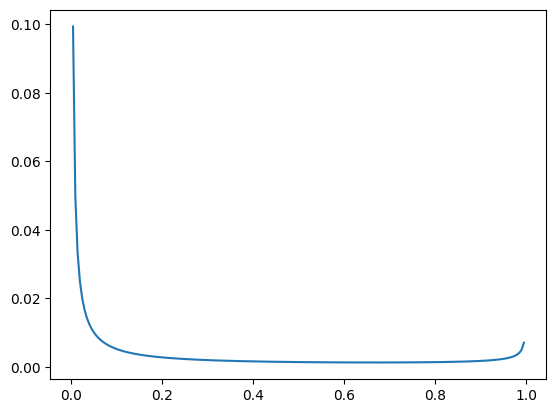

In [83]:
xs = torch.linspace(0,1,200)
ys = Beta(torch.tensor(5e-4), torch.tensor(5e-1)).log_prob(xs)

plt.plot( xs, torch.exp(ys).detach())

Interestingly, this is a second way to acheive an distribution that is almost all zeros: making one of the parameters very low, and the other less low. Of course, bigger is still better for the large parameter.

## Results

In [2]:
%run groundTruth.py
%run agents_clean.py

Text(0.5, 1.0, 'Learned Confidence')

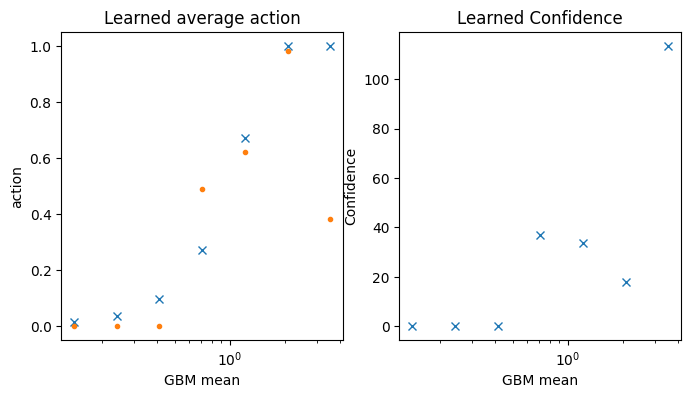

In [93]:
import glob
from agents import ConstantLearner
checkpointFileNames = glob.glob('lightning_logs/naturalGradLargeSweep/*/*')

models = [BetaDistributionLearner.load_from_checkpoint(ckpFile) for ckpFile in checkpointFileNames]

mus = []
theory = []
learned = []
confidence = []

for model in models:
    mus.append( model.hparams.mu )
    theory.append(  findBestAction_determ(model.hparams.mu, model.hparams.sigma, 1., np.sqrt).x[0] )
    learned.append( model.actionStatistics( torch.tensor([0.5, 0.5, 9.]))[0].item() )
    confidence.append( model.forward( torch.tensor([0.5, 0.5, 9.])).sum().item() )


    
figsize(8, 4)
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned, '.')
plt.xlabel('GBM mean')
plt.ylabel('action')
plt.title('Learned average action')

plt.subplot(1,2,2)
plt.semilogx(mus, confidence,'x')
plt.xlabel('GBM mean')
plt.ylabel('Confidence')
plt.title('Learned Confidence')

In [94]:
checkpointFileNames

['lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu0.1412537395954132-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu0.707945704460144-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu1.2115275859832764-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu2.073321580886841-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu0.4136820435523987-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu3.5481340885162354-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt',
 'lightning_logs/naturalGradLargeSweep/naturalGradLarge-mu0.24173153936862943-sigma2-utilityFnsqrt/epoch=399-step=40000.ckpt']

In [95]:
model = BetaDistributionLearner.load_from_checkpoint(checkpointFileNames[-2])

In [96]:
model.forward(torch.arange(0, 10)[:, None].repeat(1, 3))

tensor([[41.5494, 69.8013],
        [39.9162, 72.2133],
        [14.7957,  0.4998],
        [11.7174,  0.3652],
        [ 9.5660,  0.4140],
        [49.6125, 83.1390],
        [17.3983,  0.3049],
        [15.3887,  0.3206],
        [15.8390,  0.3998],
        [43.4584, 69.9413]], grad_fn=<AddBackward0>)

In [99]:
model.actionStatistics(torch.arange(0, 10)[:, None].repeat(1, 3))[0]

tensor([[0.3731],
        [0.3560],
        [0.9673],
        [0.9698],
        [0.9585],
        [0.3737],
        [0.9828],
        [0.9796],
        [0.9754],
        [0.3832]], grad_fn=<DivBackward0>)

This is an awfully strange result to have learned. It goes close to 100% at some timepoints, but not at others. I think that this is probably a reflection of too high of variance in the rewards. We are using a the cash-out as a baseline, but as the mean growth gets larger, this baseline becomes worse, which results in more variance in the learner. This is exactly the kind of thing that actor-critic can handle.

Text(0.5, 1.0, 'Learned Confidence')

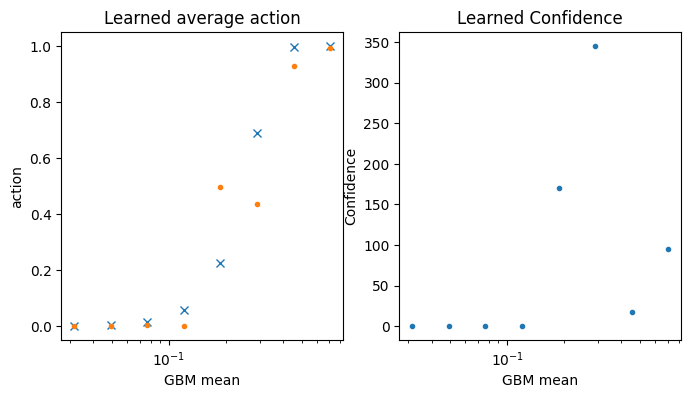

In [17]:
import glob
checkpointFileNames = glob.glob('lightning_logs/MediumParamsConstantNaturalGradSweep/*/*')

models = [ConstantBDLearner.load_from_checkpoint(ckpFile) for ckpFile in checkpointFileNames]

mus = []
theory = []
learned = []
confidence = []

for model in models:
    mus.append( model.hparams.mu )
    theory.append(  findBestAction_determ(model.hparams.mu*10, model.hparams.sigma*10**0.5, 1., np.sqrt).x[0] )
    learned.append( model.actionStatistics( torch.tensor([0.5, 0.5, 9.]))[0].item() )
    confidence.append( model.forward( torch.tensor([0.5, 0.5, 9.])).sum().item() )


    
figsize(8, 4)
plt.subplots(1,2)

plt.subplot(1,2,1)
plt.semilogx(mus, theory, 'x')
plt.semilogx(mus, learned, '.')
plt.xlabel('GBM mean')
plt.ylabel('action')
plt.title('Learned average action')

plt.subplot(1,2,2)
plt.semilogx(mus, confidence,'.')
plt.xlabel('GBM mean')
plt.ylabel('Confidence')
plt.title('Learned Confidence')

#### How does the learned constant solution compare to the solutions at different times?

2
3
4
5
6
7
8
9


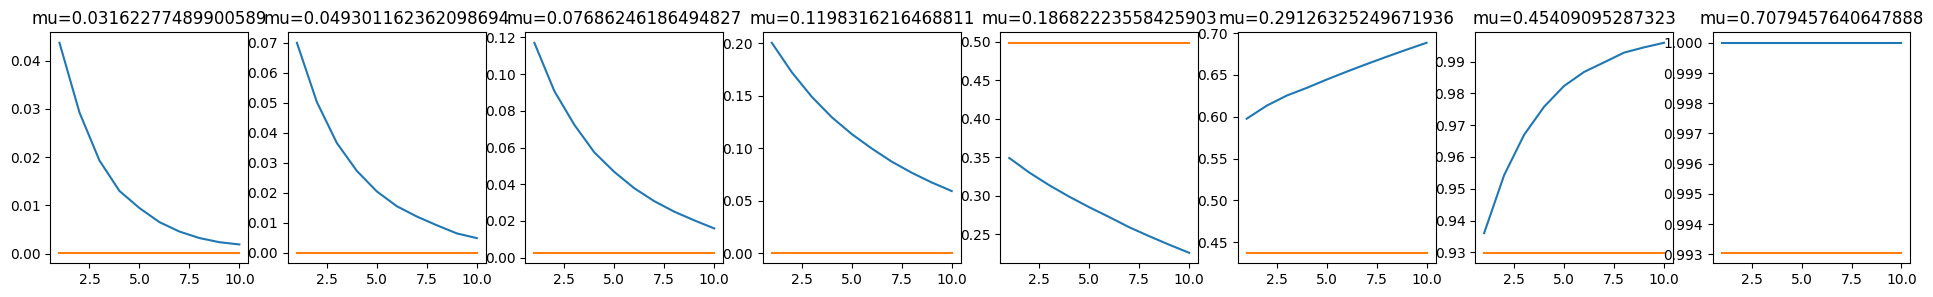

In [33]:
figsize(24, 3)
plt.subplots(1, 8)

models.sort(key=lambda model: model.hparams.mu)
Ts = np.arange(1, 11)

i = 1
for model in models:
    plt.subplot(1,8,i)
    plt.title('mu={mu}'.format(mu=model.hparams.mu) )
    
    solutions = []
    for t in Ts:
        opt = findBestAction_determ(model.hparams.mu*t, model.hparams.sigma*t**0.5, 1., np.sqrt).x[0]
        solutions.append(opt)

    plt.plot(Ts, solutions)
    plt.plot(Ts, 10*[model.actionStatistics( torch.tensor([0.5, 0.5, 7.]))[0].item()] )

    i += 1
    print(i)




Overall, these fits are not great, but not terrible either. They don't interset the ground truth lines anywhere, but are somewhat close.